# Chapter 5
## Classification

In [87]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression # LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l

from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

no display found. Using non-interactive Agg backend

In [88]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Define paths to data sets. if you don't keep your data in the same directory as the code, adapt the path names.

In [89]:
LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
FULL_TRAIN_SET_CSV = DATA / 'full_train_set.csv.gz'

## Naive Bayes

## The Naive Solution
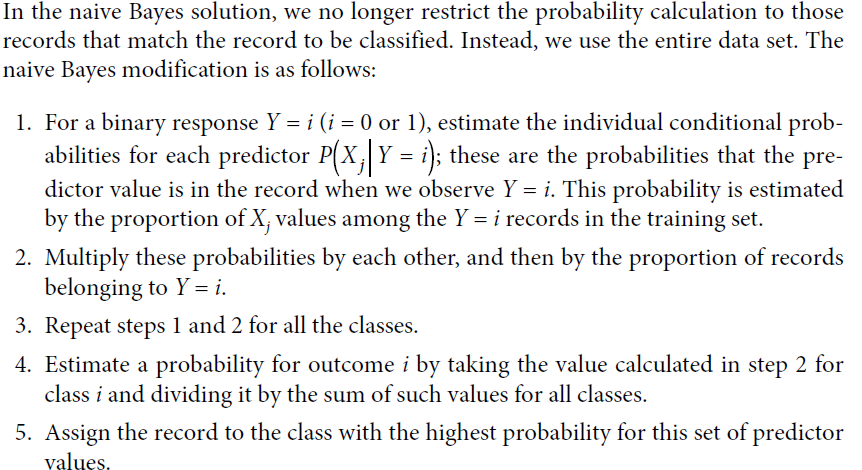

In [90]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45342 entries, 0 to 45341
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         45342 non-null  int64  
 1   status             45342 non-null  object 
 2   loan_amnt          45342 non-null  int64  
 3   term               45342 non-null  object 
 4   annual_inc         45342 non-null  int64  
 5   dti                45342 non-null  float64
 6   payment_inc_ratio  45342 non-null  float64
 7   revol_bal          45342 non-null  int64  
 8   revol_util         45342 non-null  float64
 9   purpose            45342 non-null  object 
 10  home_ownership     45342 non-null  object 
 11  delinq_2yrs_zero   45342 non-null  int64  
 12  pub_rec_zero       45342 non-null  int64  
 13  open_acc           45342 non-null  int64  
 14  grade              45342 non-null  float64
 15  outcome            45342 non-null  object 
 16  emp_length         453

In [91]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.home_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

# In Python we can use sklearn.naive_bayes.MultinomialNB from scikit-learn. We
# need to convert the categorical features to dummy variables before we fit the model:
predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model = MultinomialNB(alpha=0, fit_prior=False)
naive_model.fit(X, y)

# The model can be used to predict the outcome of a new loan
new_loan = X.loc[146:146, :]

# As we discussed, scikit-learn’s classification models have two methods—predict,
# which returns the predicted class, and predict_proba, which returns the class
# probabilities:
print('predicted class: ', naive_model.predict(new_loan)[0])

probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                                columns=naive_model.classes_)

# probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
#                                 columns=loan_data[outcome].cat.categories)

print('prediticted probalities',)
print(probabilities)

predicted class:  paid off
prediticted probalities
    default  paid off
0  0.432964  0.567036


C:\Users\batara\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


## Example not in book

Numerical variables are not supported in scikit-learn. The example would need to demonstrate binning a varible and Display the probability distribution of the bins.
```
# example not in book
less_naive <- NaiveBayes(outcome ~ borrower_score + payment_inc_ratio + 
                            purpose_ + home_ + emp_len_, data = loan_data)
                            
less_naive$table[1:2]

png(filename=file.path(PSDS_PATH, 'figures', 'psds_naive_bayes.png'), width = 4, height=3, units='in', res=300)

stats <- less_naive$table[[1]]
ggplot(data.frame(borrower_score=c(0,1)), aes(borrower_score)) +
    stat_function(fun = dnorm, color='blue', linetype=1,
                    arg=list(mean=stats[1, 1], sd=stats[1, 2])) +
    stat_function(fun = dnorm, color='red', linetype=2,
                    arg=list(mean=stats[2, 1], sd=stats[2, 2])) +
    labs(y='probability')
dev.off()
```

## Discriminant Analysis
## A Simple Example

In [92]:
loan3000 = pd.read_csv(LOAN3000_CSV)
loan3000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3000 non-null   int64  
 1   outcome            3000 non-null   object 
 2   purpose_           3000 non-null   object 
 3   dti                3000 non-null   float64
 4   borrower_score     3000 non-null   float64
 5   payment_inc_ratio  3000 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 140.8+ KB


In [93]:
# use LinearDiscriminantAnalysis from sklearn.discriminant_analysis. The scalings_ property gives the estimated weights:
loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [94]:
# The lda function can predict the probability of “default” versus “paid off ”:
# The predict_proba method of the fitted model returns the probabilities for the “default” and “paid off ” outcomes:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                   columns=loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


### Figure 5.1

The resulting plot is shown in Figure 5-1. Data points on the left of the diagonal line
are predicted to default (probability greater than 0.5).

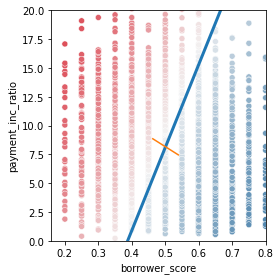

Figure 5-1. LDA prediction of loan default using two variables: a score of the borrower’s
creditworthiness and the payment-to-income ratio


In [95]:
# Use scalings and center of means to determine decision boundary
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                   hue='default', data=lda_df,
                   palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                   ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.16, 0.8)
ax.plot((x_0, x_20),(0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()
print("""Figure 5-1. LDA prediction of loan default using two variables: a score of the borrower’s
creditworthiness and the payment-to-income ratio""")

>Using the discriminant function weights, LDA splits the predictor space into two
regions, as shown by the solid line. The predictions farther away from the line in both
directions have a higher level of confidence (i.e., a probability further away from 0.5).

## Logistic Regression


## Logistic Response Function and Logit

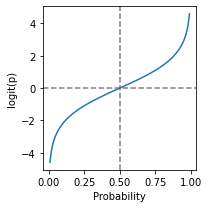

Figure 5-2. Graph of the logit function that maps a probability to a scale suitable for a
linear model 


In [96]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()
print("""Figure 5-2. Graph of the logit function that maps a probability to a scale suitable for a
linear model """)

## Logistic Regression and the GLM
The package scikit-learn has a specialised class for `LogisticRegreesion`. Statsmodels has a more general method based on generalized linear model (GLM).

>In Python, we use the scikit-learn class LogisticRegression from sklearn.lin
ear_model. The arguments penalty and C are used to prevent overfitting by L1 or L2
regularization. Regularization is switched on by default. In order to fit without regularization,
we set C to a very large value. The solver argument selects the used minimizer;
the method liblinear is the default:

In [97]:
predictors =['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_',
             'borrower_score']

outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='',
                    drop_first=True)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]},
            index=X.columns)

intercept  -1.9135151169052174
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.073295
borrower_score,4.488905
OWN,-0.035789
RENT,-0.082915
OWN,-0.035789
RENT,-0.082915
> 1 Year,0.357058


Note that the intercept and coefficients are reversed compared to the R model.

In [98]:
print(loan_data['purpose_'].cat.categories)
print(loan_data['home_'].cat.categories)
print(loan_data['emp_len_'].cat.categories)

Index(['MORTGAGE', 'OWN', 'RENT'], dtype='object')
Index(['MORTGAGE', 'OWN', 'RENT'], dtype='object')
Index([' < 1 Year', ' > 1 Year'], dtype='object')


_Not in book_ :
If you have a feature or outcome variable that is ordinal, use the scikit-learn `OrdinalEncoder` to replace the categories (herr, 'paid off' and 'default') with numbers. In the below code, we replace 'paid off' with 0 and 'default' with 1. This reverses the order of the predicted classes and as a consequence, the coefficients will be reversed.

In [99]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

logit_reg_enc = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

print('intercept', logit_reg_enc.intercept_[0])
print('classes', logit_reg_enc.classes_)
pd.DataFrame({'coeff': logit_reg_enc.coef_[0]},
            index=X.columns)

intercept 1.9135151169516427
classes [0. 1.]


,coeff
payment_inc_ratio,0.073295
borrower_score,-4.488905
OWN,0.035789
RENT,0.082915
OWN,0.035789
RENT,0.082915
> 1 Year,-0.357058


## Predicted Values from Logistic Regression
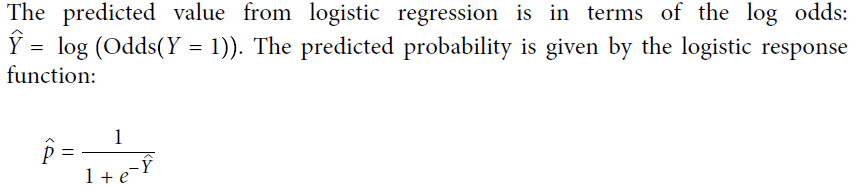

In [100]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                   columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean      -0.751025     -0.751938
std        0.356335      0.360927
min       -2.589463     -3.110623
25%       -0.963494     -0.960910
50%       -0.694703     -0.691594
75%       -0.482149     -0.480551
max       -0.045597     -0.078027


In [101]:
# The probabilities are directly available using the predict_proba methods in scikitlearn:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean       0.499996      0.500004
std        0.158874      0.158874
min        0.075060      0.044573
25%        0.381557      0.382545
50%        0.499223      0.500777
75%        0.617455      0.618443
max        0.955427      0.924940


These are on a scale from 0 to 1 and don’t yet declare whether the predicted value is
default or paid off. We could declare any value greater than 0.5 as default. In practice,
a lower cutoff is often appropriate if the goal is to identify members of a rare class

## Interprenting the Coeficients Odds ratios

>One advantage of logistic regression is that it produces a model that can be scored to
new data rapidly, without recomputation. Another is the relative ease of interpretation
of the model, as compared with other classification methods. The key conceptual
idea is understanding an odds ratio.

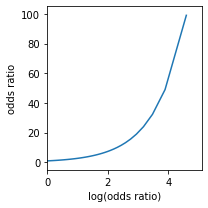

Figure 5-3. The relationship between the odds ratio and the log-odds ratio


In [102]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5, 105)

plt.tight_layout()
plt.show()
print("Figure 5-3. The relationship between the odds ratio and the log-odds ratio")

## Assessing the Model
For comparison, here the GLM model using statsmodel. This method requires that the outcomes is mapped to numbers.

As
with linear regression, some additional standard statistical tools are available to
examine and improve the model. Along with the estimated coefficients, reports the
standard error of the coefficients (SE), a z-value, and a p-value:

In [103]:
# use GLM (general Linear model) with the binomial family to fit a Logistic regression

y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(conts=1),
                     family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45336
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -29033.
Date:                Sat, 12 Mar 2022   Deviance:                       58066.
Time:                        16:01:43   Pearson chi2:                 4.53e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1003
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
payment_inc_ratio     0.0733      0.00

Many other concepts for linear regression carry over to the logistic regression setting
(and other GLMs). For example, you can use stepwise regression, fit interaction
terms, or include spline terms. The same concerns regarding confounding and correlated
variables apply to logistic regression

Uses Splines

In [104]:
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45327
Model Family:                                       Binomial   Df Model:                           14
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -29009.
Date:                                       Sat, 12 Mar 2022   Deviance:                       58018.
Time:                                               16:01:44   Pearson chi2:                 4.54e+04
No. Iterations:                                            6   Pseudo R-squ. (CS):             0.1012
Covariance Type:                                   nonrobust                      

The resulting plot is displayed in Figure 5-4. The estimated fit, shown by the line,
goes between two sets of point clouds. The top cloud corresponds to a response of 1
(defaulted loans), and the bottom cloud corresponds to a response of 0 (loans paid
off). This is very typical of residuals from a logistic regression since the output is
binary. The prediction is measured as the logit (log of the odds ratio), which will
always be some finite value. The actual value, an absolute 0 or 1, corresponds to an
infinite logit, either positive or negative, so the residuals (which get added to the fitted
value) will never equal 0. Hence the plotted points lie in clouds either above or
below the fitted line in the partial residual plot. Partial residuals in logistic regression,
while less valuable than in regression, are still useful to confirm nonlinear behavior
and identify highly influential records.


There is currently no implementation of partial residuals in any of the major Python
packages. We provide Python code to create the partial residual plot in the accompanying
source code repository.

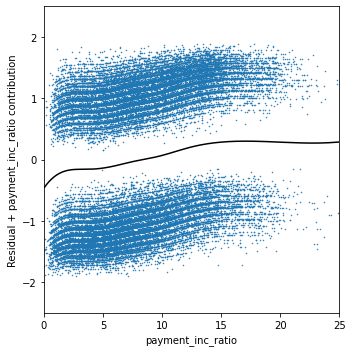

Figure 5-4. Partial residuals from logistic regression


In [105]:
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parameters of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/2,
    })
    results = results.sort_values(by=['feature'])
    
    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f"Residual + {feature} contribution")
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()
print("Figure 5-4. Partial residuals from logistic regression")

## Evaluating Classification Models

### Confusion Matrix

At the heart of classification metrics is the confusion matrix. The confusion matrix is a
table showing the number of correct and incorrect predictions categorized by type of
response. Several packages are available in R and Python to compute a confusion
matrix, but in the binary case, it is simple to compute one by hand.

In [106]:
# Confusion matrix
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & ~pred_y
false_neg = true_y & pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                        index=['Y = default', 'Y = paid off'],
                        columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default            14243            14243
Y = paid off           14314            14314


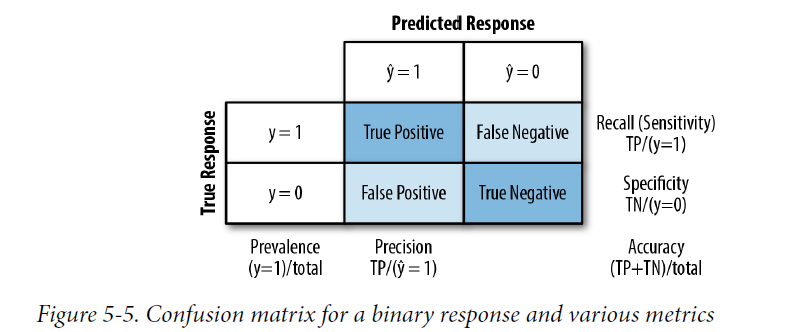

In [107]:
print(confusion_matrix(y, logit_reg.predict(X)))

[[14243  8428]
 [ 8357 14314]]


The package _dmba_ contains the function `classificationSummary` that prints confusion matrix and accuracy for a classification model. 

In [108]:
classificationSummary(y, logit_reg.predict(X),
                     class_names=logit_reg.classes_)

Confusion Matrix (Accuracy 0.6298)

         Prediction
  Actual  default paid off
 default    14243     8428
paid off     8357    14314


## Precision, Recall, and Specificity

Metrics other than pure accuracy—metrics that are more nuanced—are commonly
used in evaluating classification models. Several of these have a long history in statistics—
especially biostatistics, where they are used to describe the expected performance
of diagnostic tests.


The _Scikit-Learn_ function `precision_reacall_fscore_support` returns precision, recall, fbeta_score and support.

In [109]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precision', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('Recall', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Specificity', conf_mat[1, 1] / sum(conf_mat[1, :]))

Precision 0.6302212389380532
Recall 0.6282475409112964
Specificity 0.6313792951347537


In [110]:
precision_recall_fscore_support(y, logit_reg.predict(X),
                               labels=['default', 'paid off'])

(array([0.63022124, 0.62940814]),
 array([0.62824754, 0.6313793 ]),
 array([0.62923284, 0.63039218]),
 array([22671, 22671], dtype=int64))

## ROC Curve
The function `roc_curve` in _Scikit-Learn_ calculates all the information that is required for plotting a ROC curve.

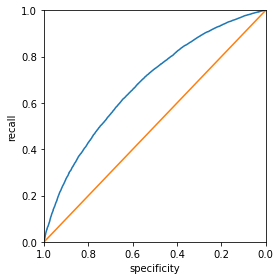

Figure 5-6. ROC curve for the loan data


In [111]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0],
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')

plt.tight_layout()
plt.show()
print("Figure 5-6. ROC curve for the loan data")

## AUC
In Python, we can either calculate the accuracy as shown for R or use scikit-learn’s
function sklearn.metrics.roc_auc_score. You will need to provide the expected
value as 0 or 1:

Accuracy can easily be calculated using the _Scikit_learn_ function `accuracy_score`.

In [112]:
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:,0]))

0.6817865275080974
0.6817867230431884


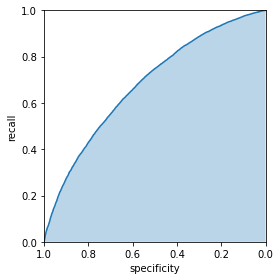

Figure 5-7. Area under the ROC curve for the loan data


In [113]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0],
                               pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)

plt.tight_layout()
plt.show()
print("Figure 5-7. Area under the ROC curve for the loan data")

## Strategies for Imbalanced Data
### Undersampling
> The results differ from the R version, however are equivalent to results obtained using the R code. Model based results are of similar magnitude.

In [114]:
full_train_set = pd.read_csv(FULL_TRAIN_SET_CSV)

print(full_train_set.shape)

(119987, 19)


In [115]:
full_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119987 entries, 0 to 119986
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   status             119987 non-null  object 
 1   loan_amnt          119987 non-null  int64  
 2   term               119987 non-null  object 
 3   annual_inc         119987 non-null  int64  
 4   dti                119987 non-null  float64
 5   payment_inc_ratio  119987 non-null  float64
 6   revol_bal          119987 non-null  float64
 7   revol_util         119987 non-null  float64
 8   purpose            119987 non-null  object 
 9   home_ownership     119987 non-null  object 
 10  delinq_2yrs_zero   119987 non-null  int64  
 11  pub_rec_zero       119987 non-null  int64  
 12  open_acc           119987 non-null  int64  
 13  grade              119987 non-null  float64
 14  outcome            119987 non-null  object 
 15  emp_length         119987 non-null  int64  
 16  pu

The
predicted values were similar: half of the probabilities were less than 0.5, and half
were greater than 0.5. In the full data set, only about 19% of the loans were in default

In [116]:
print("percentage of loans in default: ",
print(       100 * np.mean(full_train_set.outcome == "default")))

18.894546909248504
percentage of loans in default:  None


In [117]:
# What happens if we use the full data set to train the model?
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_',
              'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='',
                  drop_first=True)
y = full_train_set[outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y)
print('percentage of loans predicted to default: ',
print(     100 * np.mean(full_model.predict(X) == 'default')))

1.0067757340378543
percentage of loans predicted to default:  None


In [118]:
(np.mean(full_train_set.outcome == 'default') / 
 np.mean(full_model.predict(X) == 'default'))

18.767384105960264

## Oversampling and Up/Down Weighting
Most scikit-learn methods allow specifying weights in the fit function using the
keyword argument sample_weight

In [119]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
wt = [default_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome]

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X, y, wt)
print('percentage of loans predicted to default (weighting): ',
print(     100 * np.mean(full_model.predict(X) == 'default')))

61.03494545242402
percentage of loans predicted to default (weighting):  None


## Data Generation

The package _imbalanced-learn_ provides an implementation of the _SMOTE_ `“Synthetic Minority Oversampling Technique` and similar algorithms.

In [120]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print('percentage of loans in default (SMOTE resampled): ',
      100 * np.mean(y_resampled == 'default'))

full_mode = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_mode.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (SMOTE): ',
      100 * np.mean(full_mode.predict(X) == 'default'))

X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print('percentage of loans in default (ADASYN resampled): ',
      100 * np.mean(y_resampled == 'default'))

full_mode = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_mode.fit(X_resampled, y_resampled)
print('percentafge of loans predicted to default (ADASYN): ',
print(     100 * np.mean(full_mode.predict(X) == 'default')))

percentage of loans in default (SMOTE resampled):  50.0
percentage of loans predicted to default (SMOTE):  30.156600298365653
percentage of loans in default (ADASYN resampled):  48.56040383751355
27.34379557785427
percentafge of loans predicted to default (ADASYN):  None


## Exploring the Predictions

In [144]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                  min_impurity_decrease=0.003)

loan_tree.fit(X, y)

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

logit_reg = LogisticRegression(penalty="l2", solver='liblinear')
logit_reg.fit(X, y)


# model
gam = LinearGAM(s(0) + s(1))
print(gam.gridsearch(X.values, [1 if yi== 'default' else 0 for yi in y]))



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)


C:\Users\batara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


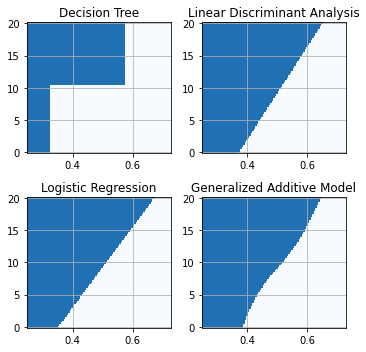

In [145]:
models = {
    'Decision Tree': loan_tree,
    'Linear Discriminant Analysis': loan_lda,
    'Logistic Regression': logit_reg,
    'Generalized Additive Model': gam,
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

xvalues = np.arange(0.25, 0.73, 0.005)
yvalues = np.arange(-0.1, 20.1, 0.1)
xx, yy = np.meshgrid(xvalues, yvalues)
X = np.c_[xx.ravel(), yy.ravel()]

boundary = {}

for n, (title, model) in enumerate(models.items()):
    ax = axes[n // 2, n % 2]
    predict = model.predict(X)
    if 'Generalized' in title:
        Z = np.array([1 if z > 0.5 else 0 for z in predict])
    else:
        
        Z = np.array([1 if z == 'default' else 0 for z in predict])
    Z = Z.reshape(xx.shape)
    boundary[title] = yvalues[np.argmax(Z > 0, axis=0)]
    boundary[title][Z[-1,:] == 0] = yvalues[-1]

    c = ax.pcolormesh(xx, yy, Z, cmap='Blues', vmin=0.1, vmax=1.3, shading='auto')
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

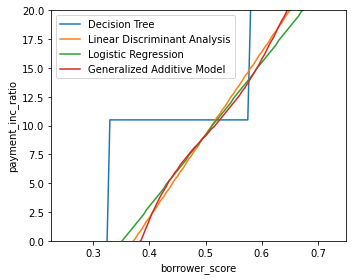

Figure 5-8. Comparison of the classification rules for four different methods


In [147]:
boundary['borrower_score']= xvalues
boundaries = pd.DataFrame(boundary)

fig , ax = plt.subplots(figsize=(5, 4))
boundaries.plot(x='borrower_score', ax=ax)
ax.set_ylabel('payment_inc_ratio')
ax.set_ylim(0, 20)

plt.tight_layout()
plt.show()
print("Figure 5-8. Comparison of the classification rules for four different methods")

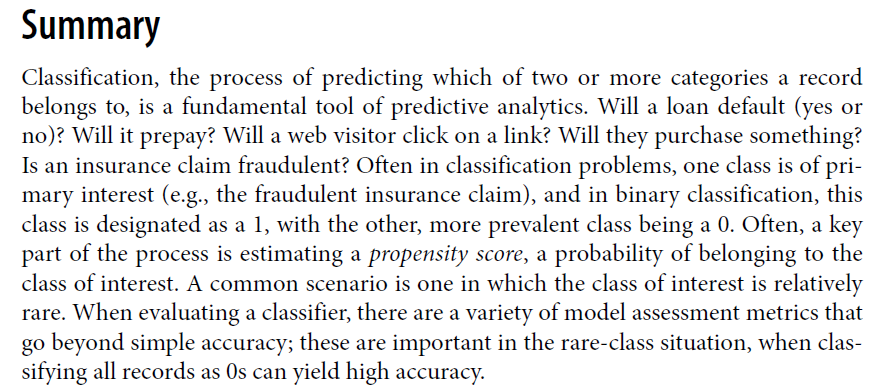